## 1.Hounsfield Units Clipping

In [1]:
import os
import shutil  # For copying files that don't have pixel data
import glob
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

##############################
# DICOM Processing Functions #
##############################

def process_dicom_file(input_filepath, output_filepath, hu_range=(-10000, 3000)):
    """
    Preprocess a single DICOM file:
      - Read the DICOM file.
      - If it lacks pixel data, copy it as-is.
      - Otherwise:
          - Convert raw pixel data to Hounsfield Units (HU).
          - Clip the HU values to the specified range.
          - Update the dataset and save the file.
    """
    ds = pydicom.dcmread(input_filepath)
    
    # If the file doesn't contain pixel data, copy it directly.
    if "PixelData" not in ds:
        shutil.copy(input_filepath, output_filepath)
        return

    # Convert pixel data to float32 for computation.
    pixel_array = ds.pixel_array.astype(np.float32)
    rescale_slope = float(ds.get('RescaleSlope', 1))
    rescale_intercept = float(ds.get('RescaleIntercept', 0))

    # Convert to Hounsfield Units (HU) and clip to the specified range.
    hu_array = pixel_array * rescale_slope + rescale_intercept
    hu_array = np.clip(hu_array, hu_range[0], hu_range[1])

    # Convert back to int16 and update the dataset.
    clipped_pixels = hu_array.astype(np.int16)
    ds.PixelData = clipped_pixels.tobytes()
    ds.PixelRepresentation = 1  # 1 means signed integers
    ds.save_as(output_filepath)

def process_dicom_folder(input_folder, output_folder, hu_range=(-10000, 3000)):
    """
    Process all DICOM files in the input folder and save the results to the output folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith('.dcm'):
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, filename)
            try:
                process_dicom_file(input_filepath, output_filepath, hu_range)
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

##########################################
# DICOM Sorting and Slice Selection Code #
##########################################

def get_slice_z(filepath):
    """
    Extract a z-coordinate for sorting from a DICOM file.
    Prioritizes ImagePositionPatient (3rd element), then SliceLocation, then InstanceNumber.
    """
    try:
        ds = pydicom.dcmread(filepath, stop_before_pixels=True)
        if 'ImagePositionPatient' in ds:
            return float(ds.ImagePositionPatient[2])
        elif 'SliceLocation' in ds:
            return float(ds.SliceLocation)
        elif 'InstanceNumber' in ds:
            return float(ds.InstanceNumber)
    except Exception:
        pass
    return 0.0

def load_and_sort_dicom_files(folder_path):
    """
    Load all DICOM file paths from the given folder and sort them based on slice position.
    """
    dicom_files = glob.glob(os.path.join(folder_path, "*.dcm"))
    # Pair each file with its z-coordinate and sort by that value.
    file_z_pairs = [(fp, get_slice_z(fp)) for fp in dicom_files]
    file_z_pairs.sort(key=lambda x: x[1])
    sorted_files = [fp for fp, z in file_z_pairs]
    return sorted_files

def compute_median_z(file_paths):
    """
    Compute the median z-coordinate from a list of DICOM file paths.
    """
    z_values = [get_slice_z(fp) for fp in file_paths]
    if z_values:
        return np.median(z_values)
    return 0.0

def find_closest_slice_index(file_paths, target_z):
    """
    Find the index of the slice whose z-coordinate is closest to the target value.
    """
    best_index = 0
    best_diff = float('inf')
    for i, fp in enumerate(file_paths):
        z = get_slice_z(fp)
        diff = abs(z - target_z)
        if diff < best_diff:
            best_diff = diff
            best_index = i
    return best_index

Processing folder: ../data/raw/CBCT -> ../data/hf/CBCT
Processing folder: ../data/raw/CT -> ../data/hf/CT


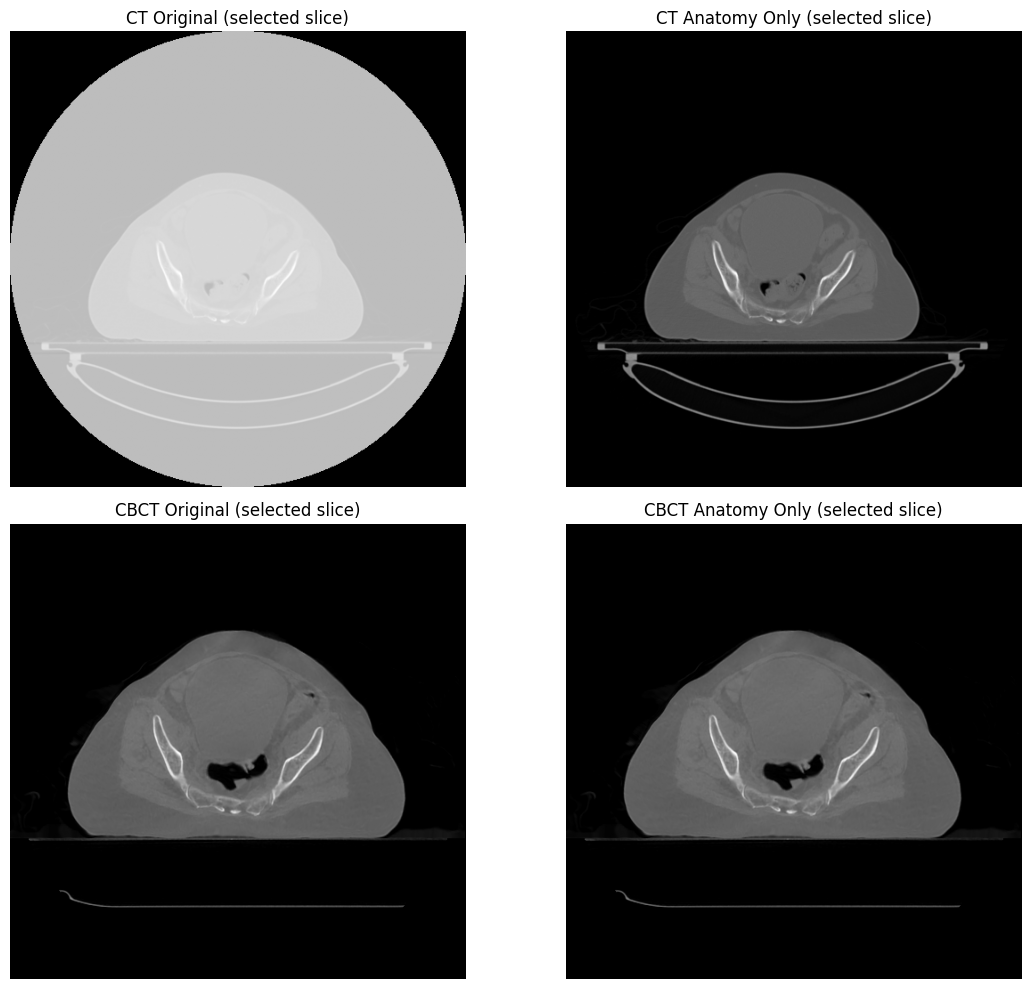

In [2]:
###################
# Main Execution  #
###################

if __name__ == "__main__":
    # Define folder pairs for raw and processed (anatomy only) DICOM files.
    folder_pairs = {
        "../data/raw/CBCT": "../data/hf/CBCT",
        "../data/raw/CT": "../data/hf/CT"
    }
    
    # Define the HU clipping range.
    hu_range = (-1000, 3000)
    
    # Process each folder pair.
    for input_folder, output_folder in folder_pairs.items():
        print(f"Processing folder: {input_folder} -> {output_folder}")
        process_dicom_folder(input_folder, output_folder, hu_range)

    # Load and sort DICOM file paths for each modality and processing type.
    ct_files_raw   = load_and_sort_dicom_files("../data/raw/CT")
    ct_files_hf    = load_and_sort_dicom_files("../data/hf/CT")
    cbct_files_raw = load_and_sort_dicom_files("../data/raw/CBCT")
    cbct_files_hf  = load_and_sort_dicom_files("../data/hf/CBCT")
    
    # Use the CT raw median slice as the reference anatomical level.
    target_z = compute_median_z(ct_files_raw)
    
    # Find the slice indices closest to the reference for each dataset.
    ct_index_raw   = find_closest_slice_index(ct_files_raw, target_z)
    ct_index_hf    = find_closest_slice_index(ct_files_hf, target_z)
    cbct_index_raw = find_closest_slice_index(cbct_files_raw, target_z)
    cbct_index_hf  = find_closest_slice_index(cbct_files_hf, target_z)
    
    # Load the selected slices.
    dicom_data_raw_ct = pydicom.dcmread(ct_files_raw[ct_index_raw])
    image_raw_ct = dicom_data_raw_ct.pixel_array

    dicom_data_hf_ct = pydicom.dcmread(ct_files_hf[ct_index_hf])
    image_hf_ct = dicom_data_hf_ct.pixel_array

    dicom_data_raw_cbct = pydicom.dcmread(cbct_files_raw[cbct_index_raw])
    image_raw_cbct = dicom_data_raw_cbct.pixel_array

    dicom_data_hf_cbct = pydicom.dcmread(cbct_files_hf[cbct_index_hf])
    image_hf_cbct = dicom_data_hf_cbct.pixel_array

    ##########################
    # Display the Selected Slices
    ##########################
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.title("CT Original (selected slice)")
    plt.imshow(image_raw_ct, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 2, 2)
    plt.title("CT Anatomy Only (selected slice)")
    plt.imshow(image_hf_ct, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 2, 3)
    plt.title("CBCT Original (selected slice)")
    plt.imshow(image_raw_cbct, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 2, 4)
    plt.title("CBCT Anatomy Only (selected slice)")
    plt.imshow(image_hf_cbct, cmap="gray")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()


## 2.Image Cropping

In [3]:
import os
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pydicom.uid import generate_uid

def world_to_pixel(coords, dicom_data):
    """
    Convert world (real-world) coordinates (in mm) to pixel coordinates using DICOM metadata.
    """
    spacing = dicom_data.PixelSpacing             # (x, y) pixel spacing in mm
    origin = dicom_data.ImagePositionPatient      # (x, y, z) image origin in mm
    pixel_coords = np.array([
        [(c[0] - origin[0]) / spacing[0], (c[1] - origin[1]) / spacing[1]]
        for c in coords
    ], dtype=np.int32)
    return pixel_coords

def get_roi_contours(rtstruct_data):
    """
    Extract ROI contours from an RTSTRUCT DICOM file.
    
    Returns:
        List of numpy arrays, each array containing the contour coordinates (x, y, z).
    """
    roi_contours = []
    for roi in rtstruct_data.StructureSetROISequence:
        print(f"Processing ROI: {roi.ROIName}")
    for roi_contour in rtstruct_data.ROIContourSequence:
        for contour_seq in roi_contour.ContourSequence:
            contour_data = np.array(contour_seq.ContourData).reshape(-1, 3)
            roi_contours.append(contour_data)
    return roi_contours

def process_dicom_series_from_folder(folder_path, tol=1e-2):
    """
    Process a DICOM series (a folder) containing one RTSTRUCT file and multiple image slices.
    
    1) Identify the RTSTRUCT file vs. image slices.
    2) Read slices, sort them by z.
    3) Find global intensity min/max across all slices.
    4) Normalize slices using the global range to 8-bit (for display/mask creation).
    5) Create segmentation masks by matching contours with each slice's z coordinate.
       (Contours that match within 'tol' in z are drawn on the slice.)
       
    Returns:
        images:        list of 8-bit images for display
        segmentations: list of 8-bit segmentation masks (white where contour is filled)
        slices:        list of tuples [(dicom_dataset, z), ...] sorted by z
    """
    files = os.listdir(folder_path)
    image_files = []
    rtstruct_file = None
    
    # Identify RTSTRUCT file vs image slices
    for f in files:
        if f.lower().endswith('.dcm'):
            full_path = os.path.join(folder_path, f)
            ds = pydicom.dcmread(full_path, stop_before_pixels=True)
            modality = ds.get("Modality", "")
            if modality == "RTSTRUCT":
                rtstruct_file = full_path
            else:
                image_files.append(full_path)
    
    if rtstruct_file is None:
        raise ValueError(f"No RTSTRUCT file found in folder: {folder_path}")
    
    # Load RTSTRUCT and get contours
    rtstruct_data = pydicom.dcmread(rtstruct_file)
    roi_contours = get_roi_contours(rtstruct_data)
    
    # Read slices and sort by z
    slices = []
    for img_file in image_files:
        ds = pydicom.dcmread(img_file)
        z = ds.ImagePositionPatient[2]
        slices.append((ds, z))
    slices.sort(key=lambda x: x[1])  # sort by z
    
    # --- 1) Find global min and max across all slices ---
    all_intensities = []
    for ds, _ in slices:
        arr = ds.pixel_array.astype(np.float32)
        all_intensities.append(arr)
    
    all_values = np.concatenate([arr.flatten() for arr in all_intensities])
    global_min = np.min(all_values)
    global_max = np.max(all_values)
    print(f"Global intensity range across all slices: [{global_min}, {global_max}]")
    
    # --- 2) Normalize each slice to 8-bit for display/mask creation ---
    images = []
    segmentations = []
    for ds, z in slices:
        arr = ds.pixel_array.astype(np.float32)
        
        # Normalize to 0-255 using the global range
        norm_arr = (arr - global_min) / (global_max - global_min)
        norm_arr = np.clip(norm_arr, 0.0, 1.0)
        image_8bit = (norm_arr * 255).astype(np.uint8)
        
        # Create a blank mask
        mask = np.zeros_like(image_8bit, dtype=np.uint8)
        
        # Draw contours for this z if matching
        match_found = False
        for contour in roi_contours:
            # If the difference in z is small enough, treat it as the same slice
            if abs(contour[0, 2] - z) < tol:
                pixel_contour = world_to_pixel(contour, ds)
                cv2.drawContours(mask, [pixel_contour], -1, 255, thickness=cv2.FILLED)
                match_found = True
        
        if not match_found:
            print(f"No ROI contours matched for slice at z = {z:.3f}")
        
        # "segmentations" array is the slice data masked by the contour
        segmentation = cv2.bitwise_and(image_8bit, image_8bit, mask=mask)
        
        images.append(image_8bit)
        segmentations.append(segmentation)
    
    return images, segmentations, slices

def save_segmentations_as_dicom(original_slices, segmentations, output_folder, prefix="seg"):
    """
    Save segmentation images as DICOM files, preserving the original data type
    (bit depth, pixel representation) from the original slices.
    
    The segmentation is stored in the same shape as the original slices, but
    we copy the relevant DICOM header information. We also generate a new UID
    for each slice.
    """
    os.makedirs(output_folder, exist_ok=True)
    
    for idx, (slice_info, seg_img_8bit) in enumerate(zip(original_slices, segmentations)):
        ds_original, _ = slice_info
        
        # Copy the original dataset
        ds_new = ds_original.copy()
        
        # Generate a new UID for the SOPInstance
        new_uid = generate_uid()
        ds_new.SOPInstanceUID = new_uid
        ds_new.file_meta.MediaStorageSOPInstanceUID = new_uid
        
        # -----------------------------------------
        # Preserve the original data type settings
        # -----------------------------------------
        bits_alloc = ds_original.BitsAllocated
        bits_stored = ds_original.BitsStored
        high_bit   = ds_original.HighBit
        pix_repr   = ds_original.PixelRepresentation
        ds_new.BitsAllocated = bits_alloc
        ds_new.BitsStored    = bits_stored
        ds_new.HighBit       = high_bit
        ds_new.PixelRepresentation = pix_repr
        
        # Depending on BitsAllocated / PixelRepresentation, convert seg_img_8bit to match
        # For example, if the original was 16-bit signed, we store the mask in 16-bit signed.
        if bits_alloc == 8:
            # 8-bit
            if pix_repr == 0:  # unsigned
                seg_img_final = seg_img_8bit.astype(np.uint8)
            else:              # signed
                seg_img_final = seg_img_8bit.astype(np.int8)
        elif bits_alloc == 16:
            # 16-bit
            if pix_repr == 0:  # unsigned
                seg_img_final = seg_img_8bit.astype(np.uint16)
            else:              # signed
                seg_img_final = seg_img_8bit.astype(np.int16)
        else:
            # Fallback (rare case where bits_alloc is something else)
            seg_img_final = seg_img_8bit.astype(np.uint16)
        
        # Update pixel data
        ds_new.PixelData = seg_img_final.tobytes()
        
        # Keep the original PhotometricInterpretation if it’s grayscale
        # (often 'MONOCHROME2' for CT). If unsure, you could explicitly set it.
        # ds_new.PhotometricInterpretation = "MONOCHROME2"
        
        # Ensure the Rows/Columns match the segmentation shape
        ds_new.Rows, ds_new.Columns = seg_img_final.shape
        
        out_filename = os.path.join(output_folder, f"{prefix}_slice_{idx:03d}.dcm")
        ds_new.save_as(out_filename)
        print(f"Saved {out_filename}")

Processing ROI: Sigmoid colon
Processing ROI: Rectum
Processing ROI: Femur_Rt
Processing ROI: Femur_Lt
Processing ROI: Bowel
Processing ROI: Bladder
Processing ROI: PTV 50
Processing ROI: CTV LN
Processing ROI: BODY
Global intensity range across all slices: [-1000.0, 3000.0]
Processing ROI: AcqIsocenter
Processing ROI: InitLaserIso
Processing ROI: InitMatchIso
Processing ROI: BODY
Global intensity range across all slices: [-1000.0, 1489.0]
Saved ../data/hf_crop/CT/seg_CT_slice_000.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_001.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_002.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_003.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_004.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_005.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_006.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_007.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_008.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_009.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_010.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_011.dcm
Save

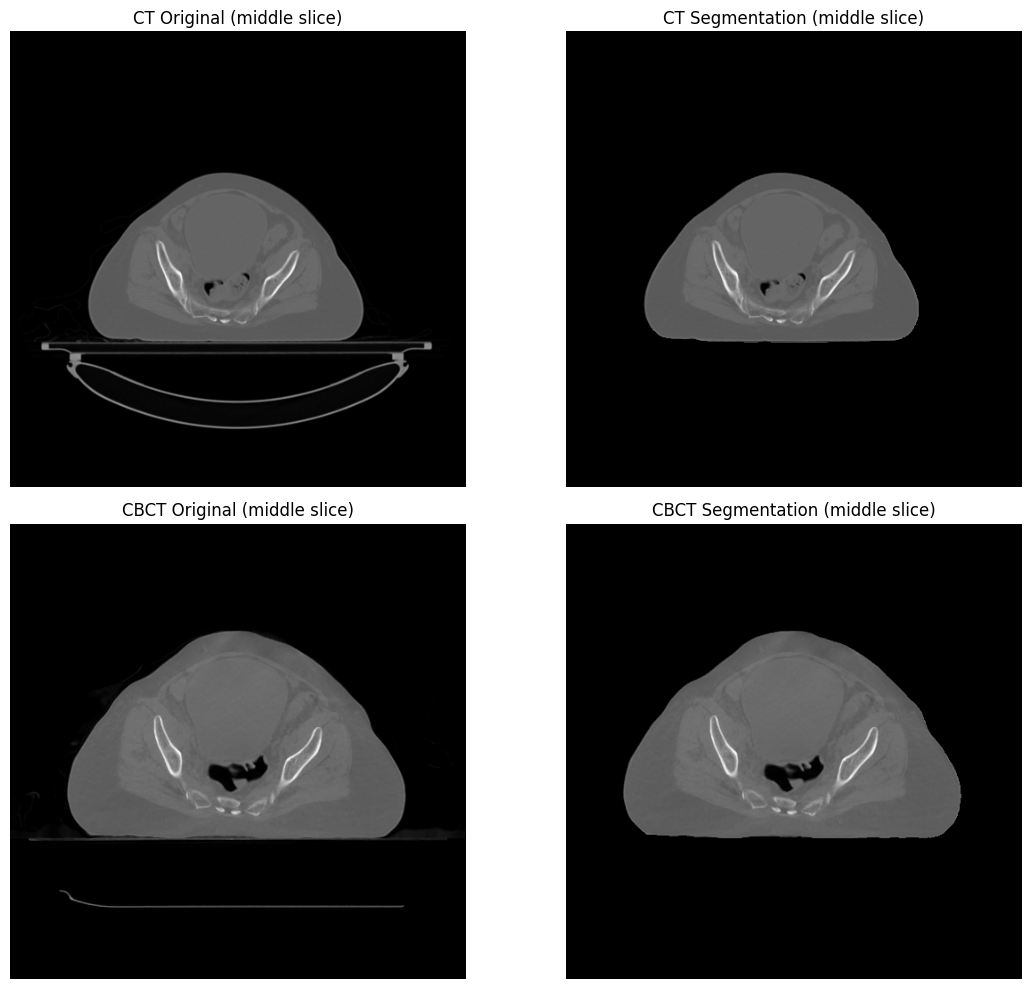

In [4]:

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    ct_input_folder = "../data/hf/CT"
    cbct_input_folder = "../data/hf/CBCT"
    
    ct_output_folder = "../data/hf_crop/CT"
    cbct_output_folder = "../data/hf_crop/CBCT"
    
    # Process CT
    ct_images, ct_segmentations, ct_slices = process_dicom_series_from_folder(
        ct_input_folder, tol=1e-2
    )
    # Process CBCT
    cbct_images, cbct_segmentations, cbct_slices = process_dicom_series_from_folder(
        cbct_input_folder, tol=1e-2
    )

    # Save segmentation outputs as new DICOM files with original datatype
    save_segmentations_as_dicom(ct_slices, ct_segmentations, ct_output_folder, prefix="seg_CT")
    save_segmentations_as_dicom(cbct_slices, cbct_segmentations, cbct_output_folder, prefix="seg_CBCT")

    # Display middle slices (optional)
    ct_mid = len(ct_images) // 2 if ct_images else 0
    cbct_mid = len(cbct_images) // 2 if cbct_images else 0
    
    plt.figure(figsize=(12, 10))

    if ct_images:
        plt.subplot(2, 2, 1)
        plt.title("CT Original (middle slice)")
        plt.imshow(ct_images[ct_mid], cmap="gray")
        plt.axis('off')
        plt.subplot(2, 2, 2)
        plt.title("CT Segmentation (middle slice)")
        plt.imshow(ct_segmentations[ct_mid], cmap="gray")
        plt.axis('off')
    
    if cbct_images:
        plt.subplot(2, 2, 3)
        plt.title("CBCT Original (middle slice)")
        plt.imshow(cbct_images[cbct_mid], cmap="gray")
        plt.axis('off')
        plt.subplot(2, 2, 4)
        plt.title("CBCT Segmentation (middle slice)")
        plt.imshow(cbct_segmentations[cbct_mid], cmap="gray")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## 3.Image registration

In [5]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def read_dicom_series(dicom_directory):
    """
    Read a DICOM series from the specified directory and return a SimpleITK image.
    """
    reader = sitk.ImageSeriesReader()
    series_ids = reader.GetGDCMSeriesIDs(dicom_directory)
    if not series_ids:
        raise ValueError(f"No DICOM series found in {dicom_directory}")
    series_id = series_ids[0]
    dicom_filenames = reader.GetGDCMSeriesFileNames(dicom_directory, series_id)
    reader.SetFileNames(dicom_filenames)
    return reader.Execute()

def estimate_background_intensity(image, margin=10, strategy="corners"):
    """
    Estimate a 'background' intensity from a 3D SimpleITK image by sampling
    a region likely outside the body (e.g., corners). This is just a heuristic!

    Parameters:
    -----------
    - image: SimpleITK image
    - margin: number of pixels to sample from the border
    - strategy: one of ["corners", "min", "mean"]

    Returns:
    --------
    - A float representing the estimated background intensity.
    """
    arr = sitk.GetArrayFromImage(image)  # shape [z, y, x]

    if strategy == "min":
        # Simply take the minimum intensity in the whole volume
        return float(arr.min())

    elif strategy == "mean":
        # Take the mean intensity of the entire volume
        return float(arr.mean())

    elif strategy == "corners":
        # Sample intensities from the corners of the volume
        z_size, y_size, x_size = arr.shape
        # top slice corners
        corner_vals = arr[0, :margin, :margin].flatten().tolist()
        corner_vals += arr[0, -margin:, -margin:].flatten().tolist()
        corner_vals += arr[0, :margin, -margin:].flatten().tolist()
        corner_vals += arr[0, -margin:, :margin].flatten().tolist()

        # bottom slice corners
        corner_vals += arr[-1, :margin, :margin].flatten().tolist()
        corner_vals += arr[-1, -margin:, -margin:].flatten().tolist()
        corner_vals += arr[-1, :margin, -margin:].flatten().tolist()
        corner_vals += arr[-1, -margin:, :margin].flatten().tolist()

        # Just take the mean of these corner values
        if corner_vals:
            return float(np.mean(corner_vals))
        else:
            return float(arr.min())

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

def register_volumes(fixed_image, moving_image,
                     strategy="corners", margin=10):
    """
    Register the moving image to the fixed image using SimpleElastix.
    Dynamically set the DefaultPixelValue based on the background intensity
    in the moving image (so that out-of-bounds areas match the 'air' or
    outside region).

    Parameters
    ----------
    - fixed_image:  SimpleITK image (fixed/reference)
    - moving_image: SimpleITK image (moving)
    - strategy:     method to estimate background. One of ["corners","min","mean"]
    - margin:       integer margin for sampling if using "corners"
    """
    # Estimate background from the moving image
    bg_value = estimate_background_intensity(moving_image, margin, strategy)
    print(f"Estimated background = {bg_value:.2f} (using '{strategy}' strategy)")

    # Prepare registration
    elastix_image_filter = sitk.ElastixImageFilter()
    elastix_image_filter.SetFixedImage(fixed_image)
    elastix_image_filter.SetMovingImage(moving_image)
    elastix_image_filter.LogToConsoleOff()
    elastix_image_filter.LogToFileOff()

    # Rigid registration as an example
    rigid_param_map = sitk.GetDefaultParameterMap("rigid")

    # Assign the dynamic background value
    # NOTE: must be a string inside a list for Elastix
    rigid_param_map["DefaultPixelValue"] = [str(int(round(bg_value)))]

    # Configure parameter map
    elastix_image_filter.SetParameterMap(rigid_param_map)

    # Do the registration
    elastix_image_filter.Execute()
    return elastix_image_filter.GetResultImage()

def show_interactive_slices(fixed_image, moving_image, registered_image):
    """
    Display a slider in a Jupyter notebook that allows you
    to scroll through slices of the fixed, moving, and registered
    images side by side.
    """
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    reg_array    = sitk.GetArrayFromImage(registered_image)
    max_z = min(fixed_array.shape[0], moving_array.shape[0], reg_array.shape[0]) - 1
    slice_slider = widgets.IntSlider(value=max_z // 2, min=0, max=max_z, step=1, description='Slice')

    def view_slice(slice_index):
        plt.close('all')
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(fixed_array[slice_index, :, :], cmap='gray')
        axes[0].set_title('Fixed Image')
        axes[0].axis('off')

        axes[1].imshow(moving_array[slice_index, :, :], cmap='gray')
        axes[1].set_title('Moving Image')
        axes[1].axis('off')

        axes[2].imshow(reg_array[slice_index, :, :], cmap='gray')
        axes[2].set_title('Registered Image')
        axes[2].axis('off')

        plt.show()

    widgets.interact(view_slice, slice_index=slice_slider)

In [6]:
import os
import SimpleITK as sitk
import uuid

import numpy as np  # Add this import at the top

def save_dicom_series_with_geometry(image, output_dir):
    """Saves 3D 'image' as a DICOM series with correct geometry & new UIDs."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Cast to Int16 for DICOM compatibility
    image = sitk.Cast(image, sitk.sitkInt16)
    
    size = image.GetSize()       # (x, y, z)
    spacing = image.GetSpacing() # (sx, sy, sz)
    origin = image.GetOrigin()   # (ox, oy, oz)
    direction = image.GetDirection()  # 9-element direction matrix

    # Generate filenames for each slice
    file_names = [os.path.join(output_dir, f"{i:03d}.dcm") for i in range(size[2])]
    
    # Create new Series Instance UID for the entire series
    new_series_uid = f"1.2.826.0.1.3680043.2.1125.{uuid.uuid4().int}"

    # Extract row (x) and column (y) direction vectors
    dir_x = np.array(direction[0:3])
    dir_y = np.array(direction[3:6])
    
    # Compute slice normal (cross product of row and column directions)
    slice_normal = np.cross(dir_x, dir_y)
    slice_normal /= np.linalg.norm(slice_normal)  # Normalize

    # Image Orientation (Patient) for axial slices
    iop = f"{dir_x[0]:.6f}\\{dir_x[1]:.6f}\\{dir_x[2]:.6f}\\{dir_y[0]:.6f}\\{dir_y[1]:.6f}\\{dir_y[2]:.6f}"

    # Loop through each slice to set metadata and write
    for z in range(size[2]):
        # Extract 2D slice (z-axis is third dimension in SimpleITK)
        slice_image = image[:, :, z]
        
        # Compute Image Position (Patient) using slice normal
        ipp_offset = z * spacing[2] * slice_normal
        ipp = np.array(origin) + ipp_offset
        ipp_str = f"{ipp[0]:.6f}\\{ipp[1]:.6f}\\{ipp[2]:.6f}"

        # Create metadata dictionary
        meta_dict = {
            "0008|0008": "ORIGINAL\\PRIMARY\\AXIAL",
            "0008|0060": "CT",
            "0010|0010": "Test^Patient",
            "0020|000e": new_series_uid,  # Series Instance UID
            "0008|0018": f"1.2.826.0.1.3680043.2.1125.{uuid.uuid4().int}",  # SOP Instance UID
            "0020|0013": str(z + 1),  # Instance Number
            "0028|0030": f"{spacing[1]:.6f}\\{spacing[0]:.6f}",  # Pixel spacing (y, x)
            "0018|0050": f"{spacing[2]:.3f}",  # Slice Thickness
            "0020|0032": ipp_str,  # Image Position (Patient)
            "0020|0037": iop,  # Image Orientation (Patient)
            # Pixel format metadata
            "0028|0100": "16",  # Bits Allocated
            "0028|0101": "16",  # Bits Stored
            "0028|0102": "15",  # High Bit
            "0028|0103": "1",   # Pixel Representation (1=signed)
        }

        # Attach metadata to the slice
        for key, value in meta_dict.items():
            slice_image.SetMetaData(key, value)
        
        # Write the slice
        writer = sitk.ImageFileWriter()
        writer.SetFileName(file_names[z])
        writer.SetImageIO("GDCMImageIO")
        writer.Execute(slice_image)

    print(f"Saved DICOM series to: {output_dir}")

In [34]:
if __name__ == "__main__":
    # 1. Read the DICOM volumes as before
    fixed_dicom_directory = "../data/hf_crop/CT"
    moving_dicom_directory = "../data/hf_crop/CBCT"

    fixed_image  = read_dicom_series(fixed_dicom_directory)
    moving_image = read_dicom_series(moving_dicom_directory)

    # 2. Perform registration (with dynamic background, etc.)
    registered_image = register_volumes(fixed_image, moving_image,
                                        strategy="corners", margin=10)

    bg_value = estimate_background_intensity(moving_image, margin=10, strategy="corners")

    registered_image = sitk.Clamp(
                        registered_image,
                        lowerBound=bg_value,
                        )


    # 3. Write the registered result as a new DICOM series
    show_interactive_slices(fixed_image, moving_image, registered_image)
    
    output_dicom_folder = "../data/regis/sCBCT"
    save_dicom_series_with_geometry(registered_image, output_dicom_folder)

Estimated background = -1000.00 (using 'corners' strategy)


interactive(children=(IntSlider(value=57, description='Slice', max=114), Output()), _dom_classes=('widget-inte…

Saved DICOM series to: ../data/regis/sCBCT


## 4. Covert dicom file to png image

In [32]:
import os
import glob
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

def load_dicom_line(path):
    """
    Load DICOM files from a directory, sort them by available metadata,
    and return a list of images (as float32 numpy arrays).
    """
    file_paths = glob.glob(os.path.join(path, "*"))
    
    dicoms = []
    for fp in file_paths:
        try:
            ds = pydicom.dcmread(fp)
            if 'PixelData' in ds:
                dicoms.append(ds)
        except Exception:
            continue

    if not dicoms:
        return []
    
    # Try sorting by ImagePositionPatient's Z coordinate if available
    if all(hasattr(d, 'ImagePositionPatient') for d in dicoms):
        try:
            dicoms.sort(key=lambda d: float(d.ImagePositionPatient[2]))
        except Exception:
            pass
    # Fallback to SliceLocation
    elif all(hasattr(d, 'SliceLocation') for d in dicoms):
        try:
            dicoms.sort(key=lambda d: float(d.SliceLocation))
        except Exception:
            pass
    # Next fallback: InstanceNumber
    elif all(hasattr(d, 'InstanceNumber') and d.InstanceNumber is not None for d in dicoms):
        try:
            dicoms.sort(key=lambda d: int(d.InstanceNumber))
        except Exception:
            dicoms.sort(key=lambda d: d.filename)
    else:
        # Final fallback: sort by filename
        dicoms.sort(key=lambda d: d.filename)
    
    images = []
    for d in dicoms:
        data = d.pixel_array.astype(np.float32)
        images.append(data)

    return images

def save_images(images, output_folder="dicom_images"):
    """
    Save each image in 'images' as a PNG file in 'output_folder'.
    Creates the folder if it doesn't exist.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for i, img_array in enumerate(images):
        out_path = os.path.join(output_folder, f"image_{i:03d}.png")
        plt.imsave(out_path, img_array, cmap='gray')


if __name__ == "__main__":
    # 1) Load DICOM images from the two relevant directories
    ct_images = load_dicom_line("../data/hf_crop/CT")
    cbct_images = load_dicom_line("../data/regis/sCBCT")

    # 2) Filter out slices where CBCT image is completely black
    filtered_ct_images = []
    filtered_cbct_images = []
    
    # Take the minimum of lengths in case they don't match exactly
    min_len = min(len(ct_images), len(cbct_images))

    for i in range(min_len):
        if np.mean(cbct_images[i]) == bg_value:
            continue
        else:
            # Keep both images
            filtered_ct_images.append(ct_images[i])
            filtered_cbct_images.append(cbct_images[i])

    # 3) Save the filtered images to disk
    save_images(filtered_ct_images, output_folder="../data/crop/CT")
    save_images(filtered_cbct_images, output_folder="../data/crop/CBCT")
